In [51]:
import os
os.environ['CUDA_VISIBLE_DEVICES']=""
os.environ['OMP_NUM_THREADS']="4"
os.environ['NUMBA_NUM_THREADS']="4"
os.environ['MKL_NUM_THREADS']="4"

In [52]:
%load_ext autoreload
%autoreload 2 
import pandas as pd; import anndata; import numpy as np; import gzip; import io; import h5py
import collections; import matplotlib.pyplot as plt; import time; import sys; import tqdm.notebook
import pickle; import scipy as sp; import scipy.sparse; import scipy.stats; rng=np.random.default_rng()
import PIL; PIL.Image.MAX_IMAGE_PIXELS = None; import matplotlib
%matplotlib inline
plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 1.0),
    "axes.facecolor":    (1.0, 1.0, 1.0, 1.0),
    "savefig.facecolor": (1.0, 1.0, 1.0, 1.0),
    "text.usetex": True,
})
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:

import json
import sklearn.neighbors
import sklearn.ensemble

# load data

In [54]:
with open('gene_divisions.json','r') as f:
    gene_divisions=json.load(f)

In [55]:
ad=anndata.read_h5ad('/data/spatial/moffit_merfish/original_file.h5ad')

In [56]:
gl={x:i for (i,x) in enumerate(ad.var.index)}
covar_genes=np.array([gl[x] for x in (list(gene_divisions['ligands'])+list(gene_divisions['receptors']))])
targ_genes=np.array([gl[x] for x in gene_divisions['response_genes']])

In [57]:
cell_classes,cell_class_onehots=oh_encode(ad.obs['Cell_class'])

In [58]:
cell_classes=ad.obs['Cell_class'].cat.categories
cell_class_onehots=pd.get_dummies(ad.obs['Cell_class']).values.astype(bool)

# construct network

  0%|          | 0/181 [00:00<?, ?it/s]

Text(0.5, 0, 'neighbors per node')

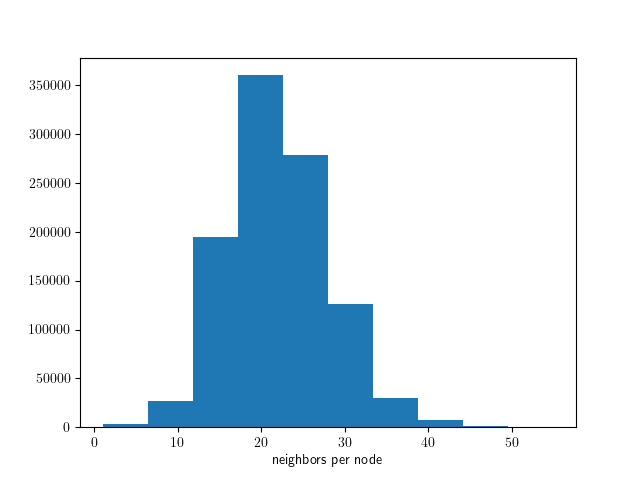

In [59]:
row=np.zeros(0,dtype=int)
col=np.zeros(0,dtype=int)

thresh=60
tissue_ids=np.unique(ad.obs['Tissue_ID'])

for tid in tqdm.notebook.tqdm(tissue_ids):
    good=ad.obs['Tissue_ID']==tid
    pos=np.array(ad.obs[good][['Centroid_X','Centroid_Y']])
    p=sklearn.neighbors.BallTree(pos)
    E=sklearn.neighbors.radius_neighbors_graph(pos,thresh,mode='connectivity', include_self=True)
    idxs=np.where(good)[0]
    col=np.r_[col,idxs[E.tocoo().col]]
    row=np.r_[row,idxs[E.tocoo().row]]
    
connectivity_matrix=sp.sparse.coo_matrix((np.ones(len(col)),(row,col)),shape=(ad.X.shape[0],ad.X.shape[0])).tocsr()
plt.hist(np.array(np.sum(connectivity_matrix,axis=1)).ravel())
plt.xlabel("neighbors per node")

# featurization

In [60]:
self_gene_features=np.log1p(ad.X[:,covar_genes])
self_ct_features = cell_class_onehots*1.0

In [61]:
neighbor_ct_features = connectivity_matrix @ cell_class_onehots
nneigh = (1e-9+np.sum(neighbor_ct_features,axis=1,keepdims=True))
neighbor_ct_features = neighbor_ct_features / nneigh
neighbor_gene_features = (connectivity_matrix @ np.log1p(ad.X[:,covar_genes])) / nneigh

In [62]:
targets=np.log1p(ad.X[:,targ_genes])

# ttsplit

In [63]:
trainset=(ad.obs['Animal_ID']<=30)
testset=ad.obs['Animal_ID']>30

trainX_withneigh=np.c_[
    self_gene_features[trainset],
    self_ct_features[trainset],
    neighbor_gene_features[trainset],
    neighbor_ct_features[trainset],
]
trainX_withoutneigh=np.c_[
    self_gene_features[trainset],
    self_ct_features[trainset],
]
trainY=targets[trainset]

testX_withneigh=np.c_[
    self_gene_features[testset],
    self_ct_features[testset],
    neighbor_gene_features[testset],
    neighbor_ct_features[testset],
]
testX_withoutneigh=np.c_[
    self_gene_features[testset],
    self_ct_features[testset],
]
testY=targets[testset]

# fit

In [69]:
print(trainX_withneigh.shape)

(893456, 174)


In [64]:
errs_withneigh=[]
errs_withoutneigh=[]
for i in tqdm.notebook.trange(targets.shape[1]):
    model=sklearn.ensemble.HistGradientBoostingRegressor()
    model.fit(trainX_withneigh,trainY[:,i])
    errs_withneigh.append(np.mean((model.predict(testX_withneigh)-testY[:,i])**2))
    
    model=sklearn.ensemble.HistGradientBoostingRegressor()
    model.fit(trainX_withoutneigh,trainY[:,i])
    errs_withoutneigh.append(np.mean((model.predict(testX_withoutneigh)-testY[:,i])**2))
    
    print(gene_divisions['response_genes'][i],errs_withoutneigh[-1],errs_withneigh[-1])

  0%|          | 0/84 [00:00<?, ?it/s]

Ace2 0.12758923246494513 0.12692094792719097


KeyboardInterrupt: 

In [ ]:
testY